In [2]:
import numpy as np
import math
from matplotlib import pyplot as plt

## Data

NOTE: for RNN, data was preprocessed in another notebook. Please see: generate_data.ipynb

In [3]:
X = np.load('trainX.npy')
Y = np.load('trainY.npy')
Y = Y.reshape(-1,1)
X.shape, Y.shape # X: [m, T, nx], Y: [m,1]

((980, 20, 1), (980, 1))

In [4]:
Xtrain = X[:700,:,:]
Xtest = X[700:,:,:]
Ytrain = Y[:700,:]
Ytest = Y[700:,:]

## Algorithm

In [5]:
class RNN():
    '''
    X: m, T, nx
    Y: m, ny
    Waa: hidden_dim, hidden_dim
    Wax: hidden_dim, nx
    Wy: ny, hidden_dim
    '''
    
    def __init__(self, hidden_dim, bptt_truncate = 5, gradient_max = 10, gradient_min = -10):
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        self.gradient_max = gradient_max
        self.gradient_min = gradient_min  
        self.layers = []
        
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.m, self.T, self.nx = X.shape
        self.ny = Y.shape[1]
        self.init_network()
        
    def train(self, n_epochs, learning_rate, method = 'many-to-one', evaluate_every_n = 20):
        
        self.method = method
        self.learning_rate = learning_rate
        
        for epoch in range(n_epochs):
            self.reset_state()
            self.forward_pass()
            self.backward_pass()
            self.SGD()
            self.compute_loss()
            if epoch % evaluate_every_n == 0:
                print('Epoch {}, Loss {}'.format(epoch, self.loss))
                
    def predict(self, X_test):
        m = X_test.shape[0]
        T = X_test.shape[1]
        
        at = np.zeros((self.hidden_dim, m))
        
        y_hat = []
        
        for t in range(T):
            if self.method == 'many-to-many' or t == self.T-1:
                out_y = True
            else:
                out_y = False
            xt = X_test[:, t, :]
            a_prev = at
            cell_output = self.RNN_cell(xt, a_prev, out_y)
            y_hat.append(cell_output['yt'])
            
        if self.method == 'many-to-one':
            y_hat = y_hat[-1]
            
        return y_hat
        
    def RNN_cell(self, xt, a_prev, out_y = False):
        '''
        xt: m, nx
        a_prev: hidden_dim, m 
    
        output:
        - at: hidden_dim, m
        - yt: m, ny or None
        - za: hidden_dim, m
        '''
        za = np.matmul(self.Wax, xt.T) + np.matmul(self.Waa, a_prev) # hidden_dim, m
        at = np.tanh(za) 
        if out_y:
            zy = np.matmul(self.Wy, at).T
            yt = zy
        else:
            zy = None
            yt = None
        return {'at':at, 'yt':yt, 'za':za}
        
    def forward_pass(self):
        at = np.zeros((self.hidden_dim, self.m))

        for t in range(self.T):
            if self.method == 'many-to-many' or t == self.T-1:
                out_y = True
            else:
                out_y = False
            xt = self.X[:, t, :]
            a_prev = at
            cell_output = self.RNN_cell(xt, a_prev, out_y)
            self.layers.append(cell_output)
    
    def backward_pass(self):

        for t in reversed(range(self.T)):
            ##### dWy
            if self.layers[t]['yt'] is not None:
                dL_dy = self.layers[-1]['yt'] - self.Y # m, ny
                dL_dWy = np.matmul(self.layers[-1]['at'], dL_dy).T # ny, hidden_dim
                self.dWy += dL_dWy

            dy_da = self.Wy # ny, hidden_dim
            dL_da = np.matmul(dL_dy, dy_da).T # hidden_dim, m

            ##### dWaa, dWax
            truncated_layers = list(range(t+1))[-self.bptt_truncate:]

            dL_dWaa = np.zeros((self.hidden_dim, self.hidden_dim))
            dL_dWax = np.zeros((self.hidden_dim, self.nx)) 

            for k in truncated_layers:
                dat_dak = np.zeros((self.hidden_dim, self.m))
                for j in range(k+1, t):
                    daj_daprev = np.matmul(self.Waa, self.d_tanh(self.layers[j]['za'])) # hidden_dim, m
                    dat_dak *= daj_daprev
                dak_dWaa = self.layers[k-1]['at'] # hidden_dim, m
                dak_dWax = self.X[:, k, :] # m, nx

                dL_dak =  dL_da * dat_dak # hidden_dim, m

                dL_dWaa_k = np.matmul(dL_dak , dak_dWaa.T) # hidden_dim, hidden_dim
                dL_dWax_k = np.matmul(dL_dak , dak_dWax) # hidden_dim, nx

                dL_dWaa += dL_dWaa_k
                dL_dWax += dL_dWax_k

            self.dWaa += dL_dWaa
            self.dWax += dL_dWax

        self.dWy,self.dWax,self.dWaa = self.gradient_clipping(self.gradient_max,self.gradient_min,
                                                         self.dWy,self.dWax,self.dWaa)
    
    def reset_state(self):
        self.layers = []
        self.dWaa = np.zeros((self.Waa.shape))
        self.dWax = np.zeros((self.Wax.shape))
        self.dWy = np.zeros((self.Wy.shape))
        
    def gradient_clipping(self, gradient_max, gradient_min, *gradients):
        '''gradients: list of ndarray'''
        for i in range(len(gradients)):
            gradients[i][np.where(gradients[i] > gradient_max)] = gradient_max
            gradients[i][np.where(gradients[i] < gradient_min)] = gradient_min
        return gradients
    
    def d_tanh(self, z):
        return 1 - (np.tanh(z))**2
    
    def SGD(self):
        self.Wy -= self.learning_rate * self.dWy
        self.Waa -= self.learning_rate * self.dWaa
        self.Wax -= self.learning_rate * self.dWax
        
    def loss_function(self, y_hat, y):
        return np.mean((y_hat - y)**2)
    
    def compute_loss(self):
        if self.method == 'many-to-one':
            y_hat = self.layers[-1]['yt']
        elif self.method == 'many-to-many':
            y_hat = [self.layers[i]['yt'] for i in range(len(self.layers)) if self.layers[i]['yt'] is not None]
        self.loss = self.loss_function(y_hat, self.Y)
        
    def init_network(self):
        self.Waa = np.random.uniform(0, 1, (self.hidden_dim, self.hidden_dim)) 
        self.Wax = np.random.uniform(0, 1, (self.hidden_dim, self.nx))
        self.Wy = np.random.uniform(0, 1, (self.ny, self.hidden_dim)) 

In [6]:
hidden_dim = 32
n_epochs = 200
learning_rate = 0.001
bptt_truncate = 5

In [7]:
rnn = RNN(hidden_dim = hidden_dim, bptt_truncate = 5, gradient_max = 10, gradient_min = -10)
rnn.fit(Xtrain, Ytrain)
rnn.train(n_epochs = n_epochs, learning_rate = learning_rate, method = 'many-to-one')
y_hat = rnn.predict(Xtrain)
y_hat_test = rnn.predict(Xtest)

Epoch 0, Loss 10.017212220924439
Epoch 20, Loss 2.107919594687538
Epoch 40, Loss 0.0009856360040947892
Epoch 60, Loss 0.0009698812131856866
Epoch 80, Loss 0.0009572150745974845
Epoch 100, Loss 0.0014552109881778028
Epoch 120, Loss 0.0021962812017525105
Epoch 140, Loss 0.0021949342490147736
Epoch 160, Loss 0.002193591210180078
Epoch 180, Loss 0.0021922520737913454


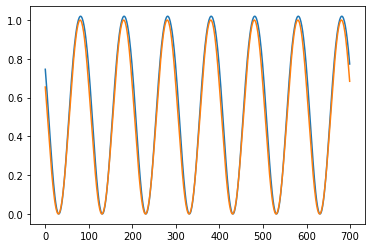

In [8]:
plt.plot(y_hat)
plt.plot(Ytrain)

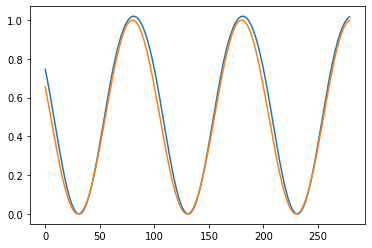

In [9]:
plt.plot(y_hat_test)
plt.plot(Ytest)

In [10]:
test_rmse = np.sqrt(rnn.loss_function(y_hat_test, Ytest))
test_rmse

0.0460031324007172

## Compare with built-in Algorithm

In [11]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Using TensorFlow backend.


In [17]:
# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(32,input_shape=(None,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
model.fit(Xtrain, Ytrain, epochs=n_epochs, batch_size=Xtrain.shape[0], verbose=0)

In [18]:
ypred = model.predict(Xtrain)

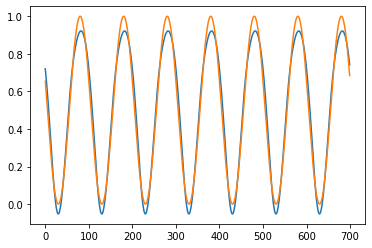

In [19]:
plt.plot(ypred)
plt.plot(Ytrain)

In [20]:
ypred = model.predict(Xtest)

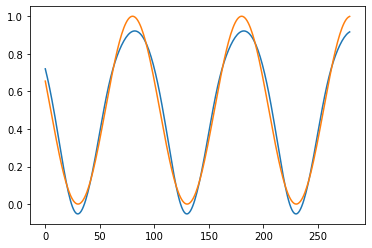

In [21]:
plt.plot(ypred)
plt.plot(Ytest)

In [22]:
test_rmse = np.sqrt(rnn.loss_function(ypred, Ytest))
test_rmse

0.051081568500525185